In [1]:
import os
import torch
import random
import numpy as np
from transformers import BertTokenizer, XLNetModel, XLNetTokenizer, XLNetForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
from EDA import *

device(type='cuda')

In [7]:
! pip install transformers

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [2]:
# import data
def read_imdb(data_dir, is_train):
    data, labels = [], []
    pos_folder_name = os.path.join(data_dir, 'train' if is_train else 'test', 'pos')
    neg_folder_name = os.path.join(data_dir, 'train' if is_train else 'test', 'neg')

    for file in os.listdir(pos_folder_name):
        with open(os.path.join(pos_folder_name, file), 'rb') as f:
            if len(data)<10000:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1)
    for file in os.listdir(neg_folder_name):
        with open(os.path.join(neg_folder_name, file), 'rb') as f:
            if len(data)<20000:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(0)
    return data, labels

In [3]:
data_dir = './aclImdb'
train_data = read_imdb(data_dir, is_train=True)
test_data = read_imdb(data_dir, is_train=False)

print('trainings:', len(train_data[0]))
print('tests:', len(test_data[0]))

for x, y in zip(train_data[0][:1], train_data[1][:1]):
    print('\nlabel:', y)
    print('review:', x)

trainings: 20000
tests: 20000

label: 1
review: Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.


In [4]:
for i in test_data[0][5000:15000]:
    train_data[0].append(i)
for i in test_data[1][5000:15000]:
    train_data[1].append(i)
del test_data[0][5000:15000]
del test_data[1][5000:15000]

In [5]:
print('train length: ',len(train_data[1]))
print('test length: ',len(test_data[1]))

train length:  30000
test length:  10000


In [6]:
# shuffle
state = np.random.get_state()
np.random.shuffle(train_data[0])
np.random.set_state(state)
np.random.shuffle(train_data[1])


state1 = np.random.get_state()
np.random.shuffle(test_data[0])
np.random.set_state(state1)
np.random.shuffle(test_data[1])

In [7]:
# tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# print(len(tokenizer.vocab))

In [8]:

train_input_ids = []
train_attention_masks = []

n=30000

for sentence in train_data[0][:n]:
    encoded = tokenizer.encode_plus(
        text=sentence,  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 128,  # maximum length of a sentence
        pad_to_max_length = True,
#         padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
    

    train_input_ids.append(encoded['input_ids'])
#     print(encoded['input_ids'])
    
   
    train_attention_masks.append(encoded['attention_mask'])

train_input_ids = torch.cat(train_input_ids)
train_attention_masks = torch.cat(train_attention_masks)
train_labels = torch.tensor(train_data[1][:n])
    

# # Get the input IDs and attention mask in tensor format
# input_ids = encoded['input_ids']
# attn_mask = encoded['attention_mask']

# 输出第 1 行文本的原始和编码后的信息
print('Original: ', train_data[0][0])
print('Token IDs:', train_input_ids[0])
print(train_labels[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/root/miniconda3/envs/myconda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  I discovered "The Patriot" in a DVD-store and thought it could be a real action thriller. No, it´s instead a low budget movie with a ridiculous story. It´s no doubt a cable-movie and not one for the theatre. Fortunately after 90 minutes the movie stops otherwise the audience should have taken an anti-virus against sleep. One thing came over: it was the nice country the film has been shot. You can really feel the American air but that´s all. I hope for Steven Seagal that he finally succeeds in a big hit. It is not a must see because I and my wife voted average 4/10.
Token IDs: tensor([    0,   100,  2967,    22,   133, 22152,   113,    11,    10, 19888,
           12,  8005,     8,   802,    24,   115,    28,    10,   588,   814,
        14481,     4,   440,     6,    24,  9900,    29,  1386,    10,   614,
         1229,  1569,    19,    10, 10861,   527,     4,    85,  9900,    29,
          117,  2980,    10,  6129,    12, 38428,     8,    45,    65,    13,
            5,  

In [9]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

27,000 training samples
3,000 validation samples


In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler



batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
        )


validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size 
        )

In [12]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", 
    num_labels = 2,
                    
    output_attentions = False, 
    output_hidden_states = False, 
    return_dict=False
)

model.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [13]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )

from transformers import get_linear_schedule_with_warmup


epochs = 3


total_steps = len(train_dataloader) * epochs


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [14]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    elapsed_rounded = int(round((elapsed)))
    
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [15]:
torch.cuda.empty_cache()

In [16]:
import random
import numpy as np

seed_val = 42
batch_size = 16
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    
    t0 = time.time()

  
    total_train_loss = 0

   
    model.train()


    for step, batch in enumerate(train_dataloader):


        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

      
        model.zero_grad()        

      
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        
        total_train_loss += loss.item()

        
        loss.backward()

        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        
        optimizer.step()


        scheduler.step()


    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
   

    print("")
    print("Running Validation...")

    t0 = time.time()

  
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
      
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
      
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
      
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

     
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))


    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
 
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

   
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    844.    Elapsed: 0:00:07.
  Batch    80  of    844.    Elapsed: 0:00:14.
  Batch   120  of    844.    Elapsed: 0:00:21.
  Batch   160  of    844.    Elapsed: 0:00:28.
  Batch   200  of    844.    Elapsed: 0:00:35.
  Batch   240  of    844.    Elapsed: 0:00:42.
  Batch   280  of    844.    Elapsed: 0:00:49.
  Batch   320  of    844.    Elapsed: 0:00:56.
  Batch   360  of    844.    Elapsed: 0:01:04.
  Batch   400  of    844.    Elapsed: 0:01:11.
  Batch   440  of    844.    Elapsed: 0:01:18.
  Batch   480  of    844.    Elapsed: 0:01:25.
  Batch   520  of    844.    Elapsed: 0:01:32.
  Batch   560  of    844.    Elapsed: 0:01:39.
  Batch   600  of    844.    Elapsed: 0:01:46.
  Batch   640  of    844.    Elapsed: 0:01:54.
  Batch   680  of    844.    Elapsed: 0:02:01.
  Batch   720  of    844.    Elapsed: 0:02:08.
  Batch   760  of    844.    Elapsed: 0:02:15.
  Batch   800  of    844.    Elapsed: 0:02:22.
  Batch   840  of

In [17]:
import pandas as pd

# 保留 2 位小数
pd.set_option('precision', 2)

# 加载训练统计到 DataFrame 中
df_stats = pd.DataFrame(data=training_stats)

# 使用 epoch 值作为每行的索引
df_stats = df_stats.set_index('epoch')

# 展示表格数据
df_stats



,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.30,0.25,0.90,0:02:30,0:00:04
2,0.19,0.26,0.91,0:02:32,0:00:04
3,0.12,0.31,0.91,0:02:32,0:00:04


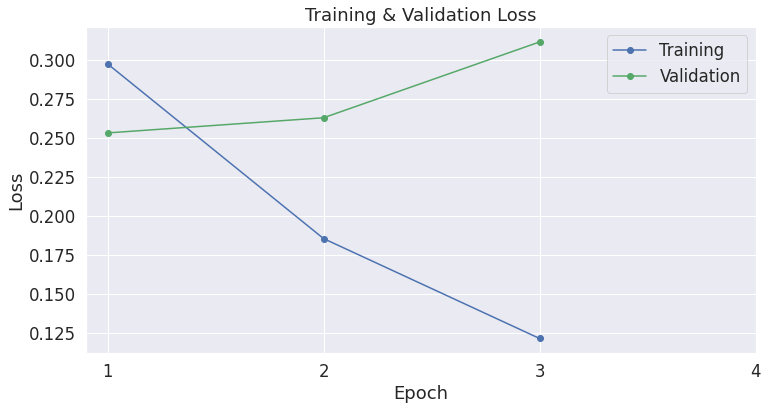

In [18]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# 绘图风格设置
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# 绘制学习曲线
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()


In [19]:

test_input_ids = []
test_attention_masks = []

n = 10000
for sentence in test_data[0][:n]:
    encoded = tokenizer.encode_plus(
        text=sentence,  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 128,  # maximum length of a sentence
        pad_to_max_length = True,
#         padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
  
   
    test_input_ids.append(encoded['input_ids'])
#     print(encoded['input_ids'])
  
  
    test_attention_masks.append(encoded['attention_mask'])


test_input_ids = torch.cat(test_input_ids)
test_attention_masks = torch.cat(test_attention_masks)
test_labels = torch.tensor(test_data[1][:n])

batch_size = 32  

prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:


print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

model.eval()

# Tracking variables 
predictions , true_labels = [], []


for batch in prediction_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():

      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #total_eval_accuracy += flat_accuracy(logits, label_ids)


   
    predictions.append(logits)
    true_labels.append(label_ids)
#avg_val_accuracy = flat_accuracy(predictions, true_labels)    
#avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
#print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
print('    DONE.')

Predicting labels for 10,000 test sentences...
    DONE.


In [21]:
print('Positive samples: %d of %d (%.2f%%)' % (sum(test_data[1]), len(test_data[1]), (sum(test_data[1]) / len(test_data[1]) * 100.0)))


Positive samples: 5000 of 10000 (50.00%)


In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pred_labels_i = []
# For each input batch...
for i in range(len(true_labels)):
    pred_labels_i += list(np.argmax(predictions[i], axis=1).flatten())

    
true_labels_list = []
for i in test_labels:
    true_labels_list.append(i.item())

accuracy_score(pred_labels_i, true_labels_list)

0.9079

Classification Report:
              precision    recall  f1-score   support

           1     0.8959    0.9230    0.9093      5000
           0     0.9206    0.8928    0.9065      5000

    accuracy                         0.9079     10000
   macro avg     0.9083    0.9079    0.9079     10000
weighted avg     0.9083    0.9079    0.9079     10000



[Text(0, 0.5, 'POS'), Text(0, 1.5, 'NEG')]

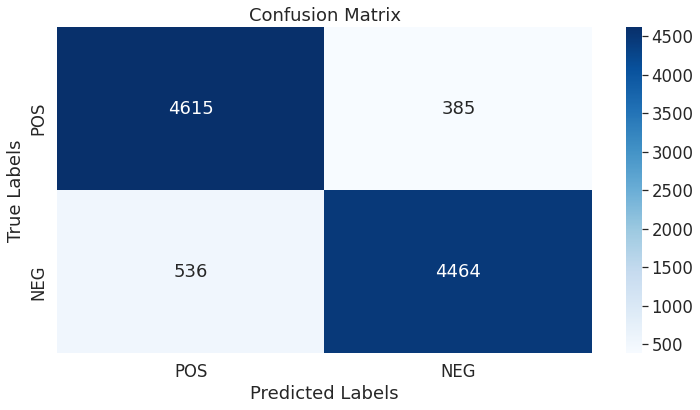

In [24]:
print('Classification Report:') 
print(classification_report(true_labels_list, pred_labels_i, labels=[1,0], digits=4)) 

cm = confusion_matrix(true_labels_list, pred_labels_i, labels=[1,0]) 
ax= plt.subplot() 
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d") 
ax.set_title('Confusion Matrix') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 
ax.xaxis.set_ticklabels(['POS', 'NEG']) 
ax.yaxis.set_ticklabels(['POS', 'NEG']) 